In [85]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.preprocessing import scale

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

## Zbiór concrete

Będziemy używać podziału na zbiór treningowy i testowy (hold-out), stąd funkcja `train_test_split`

In [87]:
data = pd.read_csv("Datasets/concrete.csv")
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y)

## Partial dependence (zależność częściowa)

Podsawą obliczania jest zasada 'ceteris paribus' (pozostali wszystcy równi). Zmienne, za wyjątkiem opisywanej ustawiane są na wartość średnią, a zmienna opisywana przyjmuje wartości w przedziale [min,max] rozłożone regularnie. Wykres pokazuje, które wartości zmiennej zwiększają modelowaną wartość (lub prawdpoodobeństwo klasy) a które zmiejszają.

In [88]:
regp_01 = DecisionTreeRegressor().fit(X, y)
regp_02 = KNeighborsRegressor().fit(X, y)
regp_03 = LinearRegression().fit(X, y)
regp_04 = MLPRegressor().fit(X, y)
regp_05 = RandomForestRegressor().fit(X, y)

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


In [89]:
pdp = partial_dependence(regp_05,X,features=["cement"])

Zmiennych opisujące wykresy znadują się w słowniku:

pdp['average'][0] - wartości pdp

pdp['values'][0] - wartości zmiennej

Wartości pdp to wynik predykcji w sytuacji, gdy wszystkie pozostałe zmienne ustawione są na ich wartości średnie, a analizowana zmienna na daną wartość 

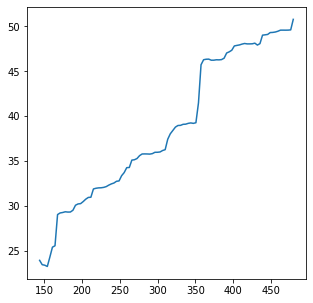

In [90]:
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(pdp['values'][0],pdp['average'][0])

Stosowane są dwie metody wyliczania:
* **brute**, - rozwiązanie "agnostyczne", możliwe dla każdego estymatora
* **recursion** - możliwe do zastosowania dla estymatorów opartych o drzewa decyzyjne (XGBoost,RandomForest) itp. Szybsze

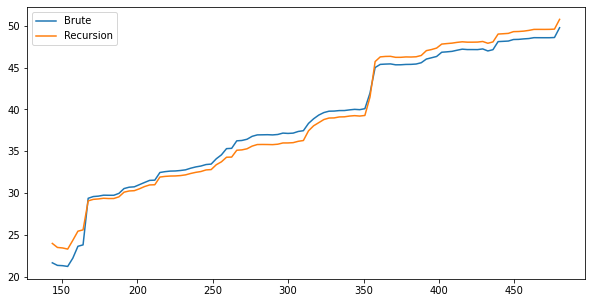

In [91]:
pdp_brute = partial_dependence(regp_05,X,features=["cement"],method="brute")
pdp_recursion = partial_dependence(regp_05,X,features=["cement"],method="recursion")
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(pdp_brute['values'][0],pdp_brute['average'][0],label="Brute")
ax.plot(pdp_recursion['values'][0],pdp_recursion['average'][0],label="Recursion")
ax.legend()


PDP nie pokazuje wpływu zmiennej na wynik, a jedynie predykcję w danych warunkach. Aby uzyskać względy wpływ danej zmiennej należy odjąć (usunąć) od otrzymanych pdp values średnią dla zmiennej zależnej. Wartość predykcji dla wszystkich wartości uśrednionych różni się znacząco od średniej wartości y

In [92]:
print(X.cement.mean())
print(y.mean(),regp_05.predict(X.mean().to_frame().T)) #mean prediction

281.16786407766995
35.817961165048544 [45.8653]


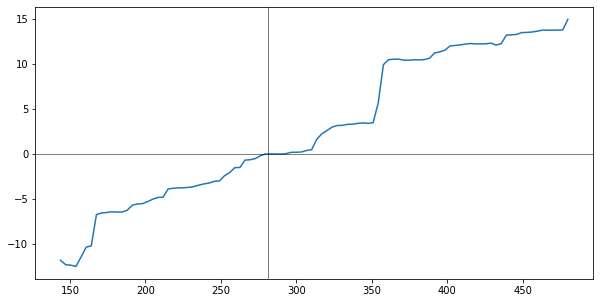

In [93]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(pdp['values'][0],pdp['average'][0]-y.mean())
ax.axhline(0,c='k',lw=0.5)
ax.axvline(X.cement.mean(),c='k',lw=0.5)

Alternatywnie, możemy zmienną zależną zamienić na jej wersję standaryzowaną. W takiej sytuacji, średnia wypadnie w wartości 0, a wpływ danej zmiennej będzie mierzony w jednostkach odchylenia standardowego zmiennej zależnej. Pozwala to porównywać modele dla różnych zmiennych zależnych.

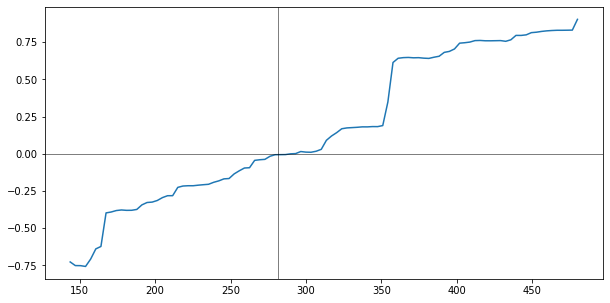

In [94]:

regp_05_scaled = RandomForestRegressor().fit(X, scale(y))
pdp_scaled = partial_dependence(regp_05_scaled,X,features=["cement"])
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(pdp_scaled['values'][0],pdp_scaled['average'][0])
ax.axhline(0,c='k',lw=0.5)
ax.axvline(X.cement.mean(),c='k',lw=0.5)

## Porówanie PDP dla różnych estymatorów

Wersja nieskalowana

Text(0.5, 0.98, 'Decision Tree')

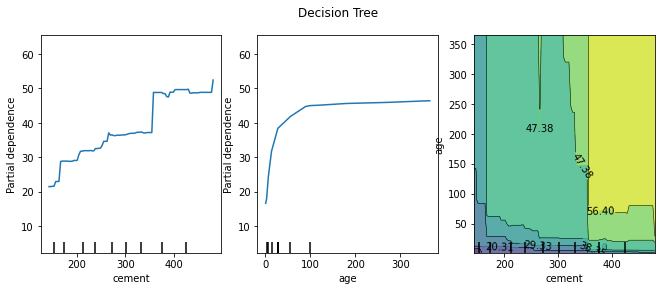

In [95]:
fig, axes = plt.subplots(ncols=3,figsize=(11,4))
PartialDependenceDisplay.from_estimator(regp_01, X, features=["cement","age",("cement","age")],ax=axes)
fig.suptitle("Decision Tree")

Text(0.5, 0.98, 'k-NN')

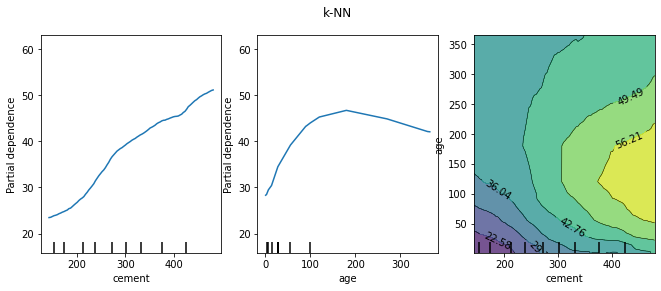

In [96]:
fig, axes = plt.subplots(ncols=3,figsize=(11,4))
PartialDependenceDisplay.from_estimator(regp_02, X, features=["cement","age",("cement","age")],ax=axes)
fig.suptitle("k-NN")

Text(0.5, 0.98, 'Linear regression')

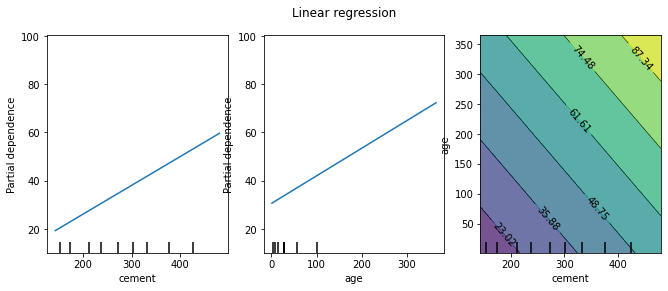

In [97]:
fig, axes = plt.subplots(ncols=3,figsize=(11,4))
PartialDependenceDisplay.from_estimator(regp_03, X, features=["cement","age",("cement","age")],ax=axes)
fig.suptitle("Linear regression")

Text(0.5, 0.98, 'Neural network')

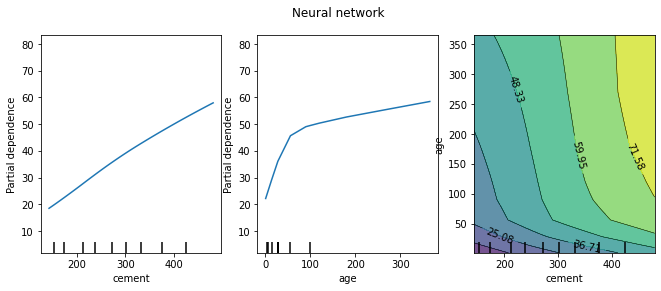

In [98]:
fig, axes = plt.subplots(ncols=3,figsize=(11,4))
PartialDependenceDisplay.from_estimator(regp_04, X, features=["cement","age",("cement","age")],ax=axes)
fig.suptitle("Neural network")

Text(0.5, 0.98, 'Random Forest')

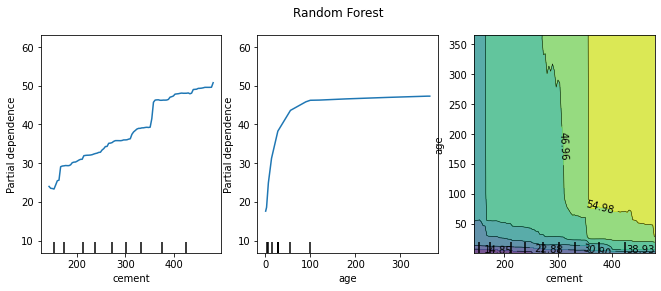

In [99]:
fig, axes = plt.subplots(ncols=3,figsize=(11,4))
PartialDependenceDisplay.from_estimator(regp_05, X, features=["cement","age",("cement","age")],ax=axes)
fig.suptitle("Random Forest")

## Accumulated local effect

W przeciwieństwie do PDP, ALE dla poszczeglnych wartości badanej zmiennej używa wartości średniej z otoczenia, gdzie dana wartość się znajduje. Pozwala to uniknąć sytuacji typowych dla PDP, że wartości średnie pozostałych zmiennych i wartość opisywanej zmiennej tworzą nieistniejącą konfigurację i tym samym wynik predykcji niewiele ma wspólnego z rzeczywistością.

Taka sytuacja ma miejsce gdy zmienne są ze sobą częściowo skorelowane i dla niektórych fragmentów przestrzeni nie ma pokrycia wartościami.

ALE zwraca wartości z usuniętą średnią, tym samym pokazuje wpływ zmiennej

Do wykonania ALE Plots użyjemy pakietu Alibi. Aliby nie akceptuje Pandas Data Frame, wymaga konwersji do numpy array. W starszych wersjach generuje warning, w nowszych error.



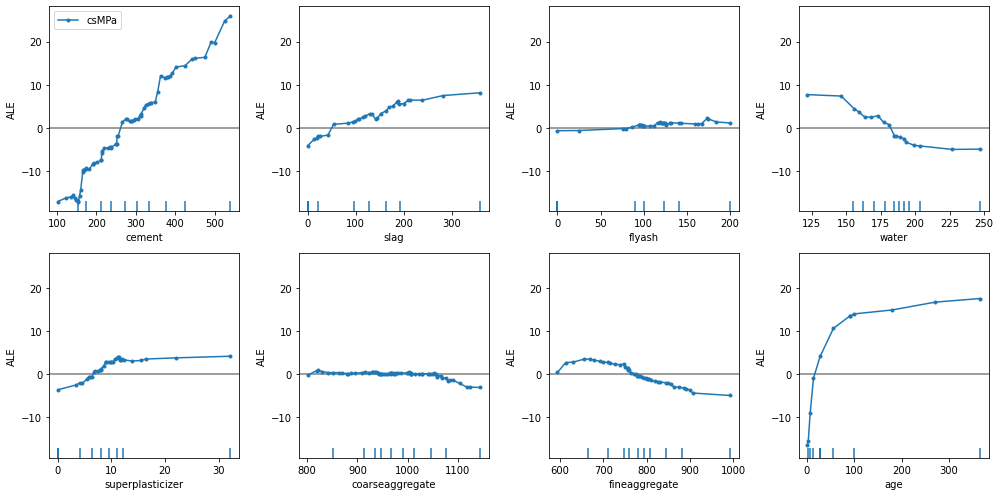

In [100]:
from alibi.explainers import ALE, plot_ale
Xn, yn = X.to_numpy(), y.to_numpy() # w celu pozbycia się feature names.
reg_05a = RandomForestRegressor().fit(Xn, yn)
reg_05_ale = ALE(reg_05a.predict, feature_names=X.columns, target_names=[y.name])
reg_05_ale_exp = reg_05_ale.explain(Xn)
_ = plot_ale(reg_05_ale_exp, n_cols=4, fig_kw={'figwidth':14, 'figheight': 7})

Dostęp do wyników niezbędnych do zbudowania wykresu odbywa się przez atrybuty:

reg_05_ale_exp.ale_values

reg_05_ale_exp.feature_values

a w starszej wersji przez elementy słownika:

reg_05_ale_exp['ale_values']

reg_05_ale_exp['feature_values']

Tym samym, porównajmy wyniki partial dependency  i accumulated local effect dla estymatora random forest.

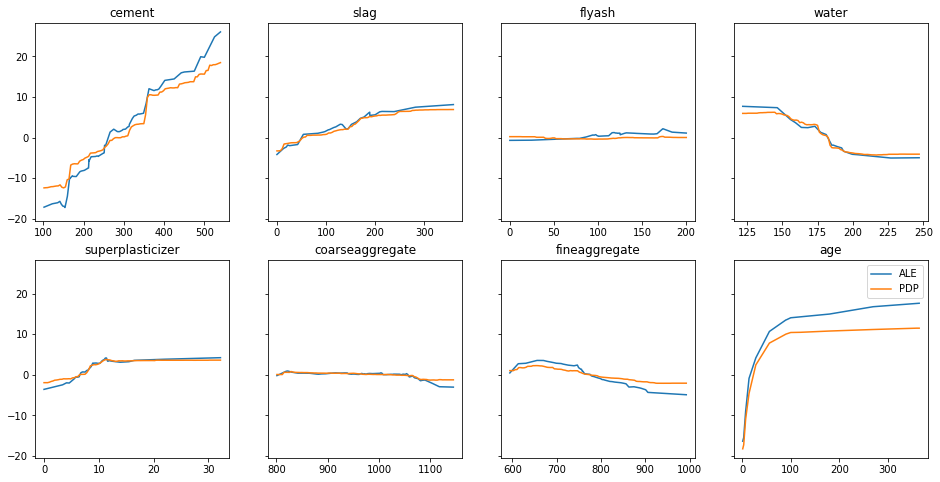

In [101]:
fig,axes = plt.subplots(ncols=4,nrows=2,figsize=(16,8),sharey=True)
fax = axes.flatten()
for i,feature in enumerate(X.columns):
    pdp = partial_dependence(regp_05,X,features=[feature],percentiles=(0,1)) # inaczej wartośc się ścięte do przedziału zmiennej 0.05,0.95
    fax[i].plot(reg_05_ale_exp.feature_values[i],reg_05_ale_exp.ale_values[i],label="ALE")
    fax[i].plot(pdp['values'][0],pdp['average'][0]-y.mean(),label='PDP')
    fax[i].set_title(feature)
_ = fax[i].legend()

## Co z klasyfikacjami

.predict() zastępujemy .predict_proba()

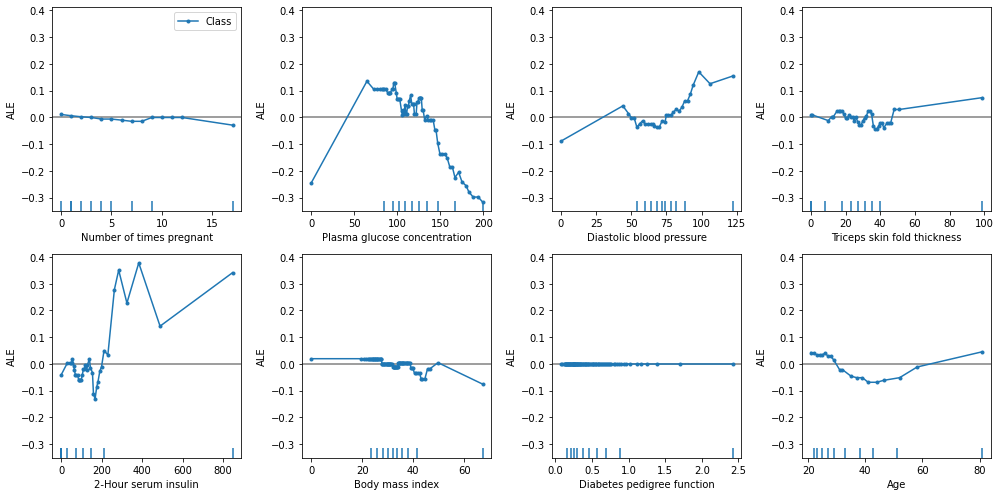

In [102]:
from sklearn.neighbors import KNeighborsClassifier

data = pd.read_csv("Datasets/diabetes_class.csv")
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
Xn, yn = X.to_numpy(), y.to_numpy()

cls_01a = KNeighborsClassifier().fit(Xn, yn)
cls_01_ale = ALE(cls_01a.predict_proba, feature_names=X.columns, target_names=[y.name]) # probability
cls_01_ale_exp = cls_01_ale.explain(Xn)
plot_ale(cls_01_ale_exp, n_cols=4, fig_kw={'figwidth':14, 'figheight': 7});

Zadanie: Przyjrzeć się ALE plots dla wybranych klasyfikatorów